#### Creating DataFrame to hold metadata of images

In [23]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Defining path to raw data
raw_data_path = Path("../data/raw/")
images_path = raw_data_path / "Images"

# Get a list of all image file paths
image_files = list(raw_data_path.glob("**/*.jpg"))

print(f"Found {len(image_files)} image files.")

# Creating list of dictionaries to build DataFrame
data = []
for f in tqdm(image_files):
    # e.g., 'n02085620-Chihuahua/n02085620_1234.jpg'
    rel_path = f.relative_to(images_path)

    # Extract the label id and the breed name
    label_id = f.parts[-2]
    breed = label_id.split("-", 1)[1]

    data.append({
        "file_path": f,
        "label_id": label_id,
        "breed": breed,
        "rel_path": str(rel_path) # Store as string for easy lookup
    })

df = pd.DataFrame(data)
print(df.head())


Found 20580 image files.


100%|██████████| 20580/20580 [00:00<00:00, 331187.71it/s]

                                           file_path                 label_id  \
0  ../data/raw/Images/n02097658-silky_terrier/n02...  n02097658-silky_terrier   
1  ../data/raw/Images/n02097658-silky_terrier/n02...  n02097658-silky_terrier   
2  ../data/raw/Images/n02097658-silky_terrier/n02...  n02097658-silky_terrier   
3  ../data/raw/Images/n02097658-silky_terrier/n02...  n02097658-silky_terrier   
4  ../data/raw/Images/n02097658-silky_terrier/n02...  n02097658-silky_terrier   

           breed                                    rel_path  
0  silky_terrier    n02097658-silky_terrier/n02097658_26.jpg  
1  silky_terrier  n02097658-silky_terrier/n02097658_4869.jpg  
2  silky_terrier   n02097658-silky_terrier/n02097658_595.jpg  
3  silky_terrier  n02097658-silky_terrier/n02097658_9222.jpg  
4  silky_terrier   n02097658-silky_terrier/n02097658_422.jpg  


#### Exploring Size of Images 

note: majority of input will need to be re-sized to a common size for model (e.g. 224x224)

In [28]:
from PIL import Image

# Just sample the sizes of 500 images since long process
image_sizes = []
for f in tqdm(df["file_path"]):
    with Image.open(f) as img:
        image_sizes.append(img.size)

# Use pandas to create a DataFrame to summarrize the sizes
size_counts = pd.Series(image_sizes).value_counts()
print("Top 5 most common image sizes:")
print(size_counts.head())

100%|██████████| 20580/20580 [00:03<00:00, 5223.64it/s]

Top 5 most common image sizes:
(500, 375)    5301
(500, 333)    2098
(375, 500)    1225
(333, 500)     706
(500, 334)     356
Name: count, dtype: int64


#### Checking number of channles in model (RGB vs grey-scale)

In [30]:
image_modes = []
for f in tqdm(df["file_path"]):
    with Image.open(f) as img:
        image_modes.append(img.mode)

# Use pandas to create a DataFrame to summarize the modes
mode_counts = pd.Series(image_modes).value_counts()
print("Image modes:")
print(mode_counts.head())

100%|██████████| 20580/20580 [00:01<00:00, 15004.47it/s]

Image modes:
RGB     20579
RGBA        1
Name: count, dtype: int64


#### Check to make sure that able to open all images (no corrupt paths)

In [31]:
corrupted_images = []
for f in tqdm(df["file_path"]):
    try:
        with Image.open(f) as img:
            img.verify()  # Verify that the image is not corrupted
    except (IOError, SyntaxError) as e:
        corrupted_images.append(f)

if not corrupted_images:
    print("All images are valid.")
else:
    print(f"Found {len(corrupted_images)} corrupted images:")
    for img in corrupted_images:
        print(img)

100%|██████████| 20580/20580 [00:03<00:00, 5440.58it/s]

All images are valid.


#### Visual Spot Checking & Outlier Detection
... make sure that a handful of the images look as we would expect (they should since it is a dataset from Stanford)

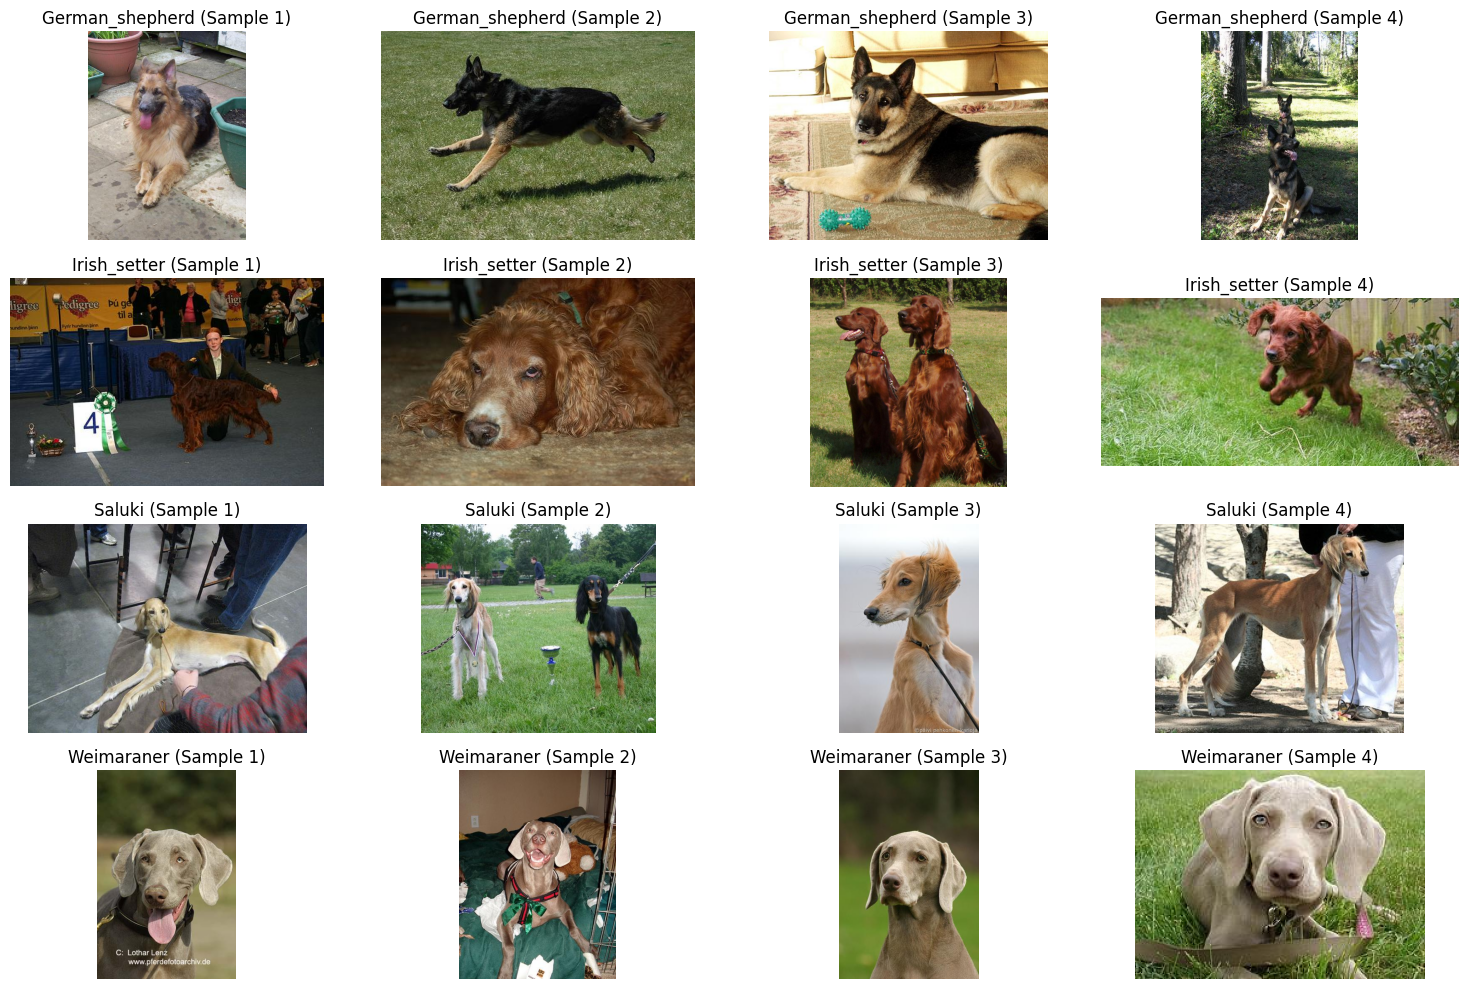

In [35]:
import matplotlib.pyplot as plt
import random

# Select a few breeds to inspect
breeds_to_check = ["German_shepherd", "Irish_setter", "Saluki", "Weimaraner"]

plt.figure(figsize=(15, 10))

for i, breed in enumerate(breeds_to_check):
    # Get all file paths for the current breed
    breed_files = df[df["breed"] == breed]["file_path"].tolist()
    
    # Select 4 random images for this breed
    random_samples = random.sample(breed_files, 4)
    
    for j, file_path in enumerate(random_samples):
        ax = plt.subplot(len(breeds_to_check), 4, i * 4 + j + 1)
        with Image.open(file_path) as img:
            ax.imshow(img)
        ax.set_title(f"{breed} (Sample {j+1})")
        ax.axis("off")

plt.tight_layout()
plt.show()

#### Analyzing Image Properties (Brightness & Contrast)

100%|██████████| 20580/20580 [00:24<00:00, 849.49it/s]


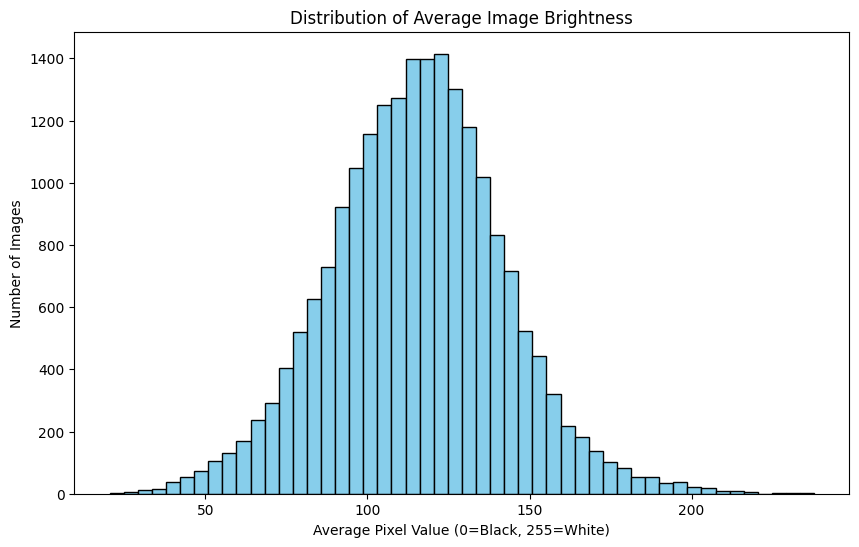

In [36]:
import numpy as np

brightness_values = []

for f in tqdm(df["file_path"]):
    with Image.open(f) as img:
        # Convert to grayscale for brightness analysis
        gray_img = img.convert("L")
        # Calculate the mean brightness
        brightness = np.mean(np.array(gray_img))
        brightness_values.append(brightness)

# Plot a histogram of brightness values
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Average Image Brightness")
plt.xlabel("Average Pixel Value (0=Black, 255=White)")
plt.ylabel("Number of Images")
plt.show()